In [1]:
import os
os.chdir('C:\\Users\\Takanori\\Desktop\\Kaggle\\TPS2204\\input')

# Introduction
Hey, thanks for viewing my Kernel!

If you like my work, please, leave an upvote: it will be really appreciated and it will motivate me in offering more content to the Kaggle community ! :)

EDA was done in this [notebook](https://www.kaggle.com/code/hasanbasriakcay/tpsapr22-eda-fe-baseline)</br>
Pseudo Labeling was done in this [notebook](https://www.kaggle.com/code/hasanbasriakcay/tpsapr22-fe-pseudo-labels-baseline)</br>
Prediction without NN is in this [notebook](https://www.kaggle.com/code/hasanbasriakcay/tpsapr22-optuna-lgbm-blend)

In [2]:
import pandas as pd
import numpy as np
import warnings 

warnings.simplefilter("ignore")
# indexを指定しないと、PyCaretの予測結果がめちゃくちゃになる?
train = pd.read_csv("../input/tabular-playground-series-apr-2022/train.csv", index_col=['sequence', 'subject', 'step'])
test = pd.read_csv("../input/tabular-playground-series-apr-2022/test.csv", index_col=['sequence', 'subject', 'step'])
labels = pd.read_csv("../input/tabular-playground-series-apr-2022/train_labels.csv")
sub = pd.read_csv("../input/tabular-playground-series-apr-2022/sample_submission.csv")

display(train.head())
display(test.head())
display(labels.head())
display(sub.head())

sensor_00  sensor_01  sensor_02  sensor_03  sensor_04  \
sequence subject step                                                          
0        47      0     -0.196291   0.112395        1.0   0.329204  -1.004660   
                 1     -0.447450   0.134454        1.0  -0.658407   0.162495   
                 2      0.326893  -0.694328        1.0   0.330088   0.473678   
                 3      0.523184   0.751050        1.0   0.976991  -0.563287   
                 4      0.272025   1.074580        1.0  -0.136283   0.398579   

                       sensor_05  sensor_06  sensor_07  sensor_08  sensor_09  \
sequence subject step                                                          
0        47      0     -0.131638  -0.127505   0.368702       -0.1  -0.963873   
                 1      0.340314  -0.209472  -0.867176        0.2  -0.301301   
                 2      1.280479  -0.094718   0.535878        1.4   1.002168   
                 3     -0.720269   0.793260   0.951145       -0.3  -0.995665   
                 4      0.044877   0.560109  -0.541985       -0.9   1.055636   

                       sensor_10  sensor_11  sensor_12  
sequence subject step                                   
0        47      0     -0.985069   0.531893   4.751492  
                 1      0.082733  -0.231481   0.454390  
                 2      0.449221  -0.586420  -4.736147  
                 3     -0.434290   1.344650   0.429241  
                 4      0.812631   0.123457  -0.223359

sensor_00  sensor_01  sensor_02  sensor_03  sensor_04  \
sequence subject step                                                          
25968    684     0      2.427357  19.639706        1.0  -1.466372  -1.289973   
                 1     -4.950541 -21.747899        1.0   0.983186  -0.569053   
                 2      1.136012 -10.756303        1.0   1.016814   0.964157   
                 3      0.806028   6.504202        1.0  -0.179646   0.969221   
                 4      1.288253   5.552521        1.0  -0.493805  -1.036124   

                       sensor_05  sensor_06  sensor_07  sensor_08  sensor_09  \
sequence subject step                                                          
25968    684     0     -4.207928   2.486339  -2.493893        8.0  -1.123555   
                 1      1.845924  -3.887978   1.727481       -2.9   0.395231   
                 2      2.454749   0.312386   1.154198       -5.6   1.114162   
                 3     -1.035153  -0.457195   0.254962       -2.7  -0.588873   
                 4     -1.126402   2.008197  -0.730534        0.0   0.899566   

                       sensor_10  sensor_11  sensor_12  
sequence subject step                                   
25968    684     0     -1.673048  10.980453   0.419011  
                 1     -0.882233  -1.871399  -0.008525  
                 2      1.525273 -11.584362   0.139812  
                 3      0.608761  -4.241770  -0.462916  
                 4     -1.259615  -0.472222  -0.121483

,sequence,state
0,0,0
1,1,1
2,2,1
3,3,1
4,4,1


,sequence,state
0,25968,0
1,25969,0
2,25970,0
3,25971,0
4,25972,0


# Feature Engineering

In [3]:
# 負と正を対象に行き来しているデータでは、平均等が意味をなさなくなるため、絶対値を取ってみる
def abs_sensors(df):
    for i in range(13):
        sensor_name = 'sensor_' + str(i).zfill(2)
        df[sensor_name + '_abs'] = np.abs(df[sensor_name])


abs_sensors(train)
abs_sensors(test)

In [4]:
# 予測するものはsequence毎のstateだが、各sequenceは60stepのデータを持つため、統計量で集約する
from scipy.stats import kurtosis
def kurtosis_func(series):
    '''
    Describe something...
    '''
    return kurtosis(series)

def q01(series):
    return np.quantile(series, 0.01)

def q05(series):
    return np.quantile(series, 0.05)

def q95(series):
    return np.quantile(series, 0.95)

def q99(series):
    return np.quantile(series, 0.99)

def aggregated_features(df, aggregation_cols = ['sequence'], prefix = ''):
    agg_strategy = {}
    for i in range(13):
        sensor_name = 'sensor_' + str(i).zfill(2)
        agg_strategy[sensor_name] = ['mean', 'max', 'min', 'var', 'mad', 'sum', 'median', 'skew', kurtosis_func, q01, q05, q95, q99]
        agg_strategy[sensor_name + '_abs'] = ['mean', 'max', 'min', 'var', 'mad', 'sum', 'median', 'skew', kurtosis_func, q01, q05, q95, q99]

    group = df.groupby(aggregation_cols).aggregate(agg_strategy)
    group.columns = ['_'.join(col).strip() for col in group.columns]
    group.columns = [str(prefix) + str(col) for col in group.columns]
    group.reset_index(inplace = True)

    temp = (df.groupby(aggregation_cols).size().reset_index(name = str(prefix) + 'size'))
    group = pd.merge(temp, group, how = 'left', on = aggregation_cols,)
    return group

* PyCaretを使ってみる
* https://pycaret.gitbook.io/docs/

In [5]:
# !pip install pycaret -full
import pycaret
from pycaret.classification import *
from pycaret.classification import setup, compare_models, blend_models, finalize_model, predict_model, plot_model

In [6]:
train = aggregated_features(train, aggregation_cols = ['sequence', 'subject'])
test = aggregated_features(test, aggregation_cols = ['sequence', 'subject'])

In [7]:
# TODO ここに、subjectの登場回数を追加する

In [8]:
# 予測対象であるstateをくっつける
train_df_label = pd.merge(train, labels, on="sequence")

In [9]:
train_df_label.tail()

,sequence,subject,size,sensor_00_mean,sensor_00_max,sensor_00_min,sensor_00_var,sensor_00_mad,sensor_00_sum,sensor_00_median,sensor_00_skew,sensor_00_kurtosis_func,sensor_00_q01,sensor_00_q05,sensor_00_q95,sensor_00_q99,sensor_00_abs_mean,sensor_00_abs_max,sensor_00_abs_min,sensor_00_abs_var,sensor_00_abs_mad,sensor_00_abs_sum,sensor_00_abs_median,sensor_00_abs_skew,sensor_00_abs_kurtosis_func,sensor_00_abs_q01,sensor_00_abs_q05,sensor_00_abs_q95,sensor_00_abs_q99,sensor_01_mean,sensor_01_max,sensor_01_min,sensor_01_var,sensor_01_mad,sensor_01_sum,sensor_01_median,sensor_01_skew,sensor_01_kurtosis_func,sensor_01_q01,sensor_01_q05,sensor_01_q95,sensor_01_q99,sensor_01_abs_mean,sensor_01_abs_max,sensor_01_abs_min,sensor_01_abs_var,sensor_01_abs_mad,sensor_01_abs_sum,sensor_01_abs_median,sensor_01_abs_skew,sensor_01_abs_kurtosis_func,sensor_01_abs_q01,sensor_01_abs_q05,sensor_01_abs_q95,sensor_01_abs_q99,sensor_02_mean,sensor_02_max,sensor_02_min,sensor_02_var,sensor_02_mad,sensor_02_sum,sensor_02_median,sensor_02_skew,sensor_02_kurtosis_func,sensor_02_q01,sensor_02_q05,sensor_02_q95,sensor_02_q99,sensor_02_abs_mean,sensor_02_abs_max,sensor_02_abs_min,sensor_02_abs_var,sensor_02_abs_mad,sensor_02_abs_sum,sensor_02_abs_median,sensor_02_abs_skew,sensor_02_abs_kurtosis_func,sensor_02_abs_q01,sensor_02_abs_q05,sensor_02_abs_q95,sensor_02_abs_q99,sensor_03_mean,sensor_03_max,sensor_03_min,sensor_03_var,sensor_03_mad,sensor_03_sum,sensor_03_median,sensor_03_skew,sensor_03_kurtosis_func,sensor_03_q01,sensor_03_q05,sensor_03_q95,sensor_03_q99,sensor_03_abs_mean,sensor_03_abs_max,sensor_03_abs_min,sensor_03_abs_var,sensor_03_abs_mad,sensor_03_abs_sum,sensor_03_abs_median,sensor_03_abs_skew,sensor_03_abs_kurtosis_func,sensor_03_abs_q01,sensor_03_abs_q05,sensor_03_abs_q95,sensor_03_abs_q99,sensor_04_mean,sensor_04_max,sensor_04_min,sensor_04_var,sensor_04_mad,sensor_04_sum,sensor_04_median,sensor_04_skew,sensor_04_kurtosis_func,sensor_04_q01,sensor_04_q05,sensor_04_q95,sensor_04_q99,sensor_04_abs_mean,sensor_04_abs_max,sensor_04_abs_min,sensor_04_abs_var,sensor_04_abs_mad,sensor_04_abs_sum,sensor_04_abs_median,sensor_04_abs_skew,sensor_04_abs_kurtosis_func,sensor_04_abs_q01,sensor_04_abs_q05,sensor_04_abs_q95,sensor_04_abs_q99,sensor_05_mean,sensor_05_max,sensor_05_min,sensor_05_var,sensor_05_mad,sensor_05_sum,sensor_05_median,sensor_05_skew,sensor_05_kurtosis_func,sensor_05_q01,sensor_05_q05,sensor_05_q95,sensor_05_q99,sensor_05_abs_mean,sensor_05_abs_max,sensor_05_abs_min,sensor_05_abs_var,sensor_05_abs_mad,sensor_05_abs_sum,sensor_05_abs_median,sensor_05_abs_skew,sensor_05_abs_kurtosis_func,sensor_05_abs_q01,sensor_05_abs_q05,sensor_05_abs_q95,sensor_05_abs_q99,sensor_06_mean,sensor_06_max,sensor_06_min,sensor_06_var,sensor_06_mad,sensor_06_sum,sensor_06_median,sensor_06_skew,sensor_06_kurtosis_func,sensor_06_q01,sensor_06_q05,sensor_06_q95,sensor_06_q99,sensor_06_abs_mean,sensor_06_abs_max,sensor_06_abs_min,sensor_06_abs_var,sensor_06_abs_mad,sensor_06_abs_sum,sensor_06_abs_median,sensor_06_abs_skew,sensor_06_abs_kurtosis_func,sensor_06_abs_q01,sensor_06_abs_q05,sensor_06_abs_q95,sensor_06_abs_q99,sensor_07_mean,sensor_07_max,sensor_07_min,sensor_07_var,sensor_07_mad,sensor_07_sum,sensor_07_median,sensor_07_skew,sensor_07_kurtosis_func,sensor_07_q01,sensor_07_q05,sensor_07_q95,sensor_07_q99,sensor_07_abs_mean,sensor_07_abs_max,sensor_07_abs_min,sensor_07_abs_var,sensor_07_abs_mad,sensor_07_abs_sum,sensor_07_abs_median,sensor_07_abs_skew,sensor_07_abs_kurtosis_func,sensor_07_abs_q01,sensor_07_abs_q05,sensor_07_abs_q95,sensor_07_abs_q99,sensor_08_mean,sensor_08_max,sensor_08_min,sensor_08_var,sensor_08_mad,sensor_08_sum,sensor_08_median,sensor_08_skew,sensor_08_kurtosis_func,sensor_08_q01,sensor_08_q05,sensor_08_q95,sensor_08_q99,sensor_08_abs_mean,sensor_08_abs_max,sensor_08_abs_min,sensor_08_abs_var,sensor_08_abs_mad,sensor_08_abs_sum,sensor_08_abs_median,sensor_08_abs_skew,sensor_08_abs_kurtosis_func,sensor_08_abs_q01,sensor_08_abs_q05

In [18]:
clf1 = setup(data = train_df_label,
             target = 'state',  # 目標変数
             ignore_features =['sequence'],
             numeric_imputation = 'mean',  # 欠損値は平均で補完
             fold_strategy = 'groupkfold',
             fold_groups = 'sequence',
             use_gpu = True,
             fold = 3,
             remove_outliers=True,
             normalize = True, 
             normalize_method = 'minmax',
             silent = True)

,Description,Value
0,session_id,1285
1,Target,state
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(25968, 342)"
5,Missing Values,False
6,Numeric Features,339
7,Categorical Features,1
8,Ordinal Features,False
9,High Cardinality Features,False


In [11]:
# 学習が進んできたらモデルを比較する。一旦はlightgbmでもそれなりに見れているのでこれで
# compare_models()

In [19]:
lightgbm_model = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8301,0.9072,0.8814,0.8041,0.8410,0.6594,0.6626
1,0.8266,0.9067,0.8598,0.8054,0.8317,0.6533,0.6548
2,0.8264,0.9067,0.8613,0.8024,0.8308,0.6531,0.6548
Mean,0.8277,0.9068,0.8675,0.8040,0.8345,0.6553,0.6574
Std,0.0017,0.0002,0.0098,0.0012,0.0046,0.0029,0.0037


In [16]:
# 影響が大きいのは
# sensor_04_kurtosis_func
# sensor_02_abs_var
# sensor_10_abs_skew
# sensor_02_max
# sensor_05_sum
# sensor_04_mean
# sensor_04_abs_median
# sensor_10_mean
# sensor_12_abs_max
# sensor_01_mean
# sensor_11_mean
# sensor_12_sum
# sensor_09_sum
# subject
# あたり
interpret_model(lightgbm_model)

LightGBMError: The number of features in data (341) is not the same as it was in training data (288).
You can set ``predict_disable_shape_check=true`` to discard this error, but please be aware what you are doing.

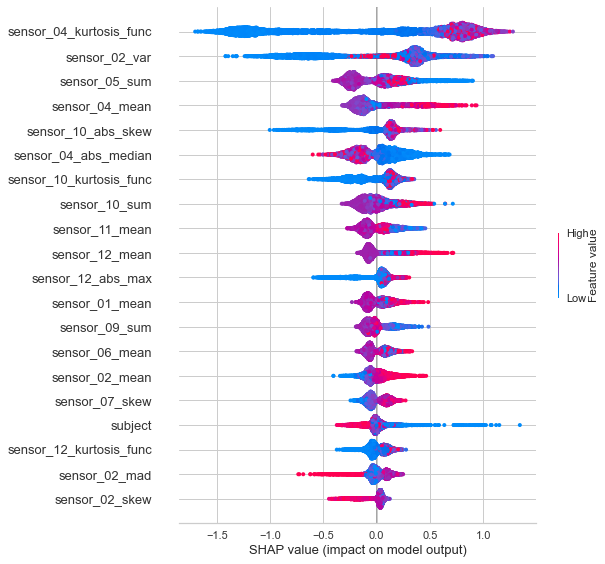

AttributeError: 'NoneType' object has no attribute 'save_interpretation'

In [26]:
interpret_model(lightgbm_model)
# save image


In [28]:
def test(remove_factor):
    display(remove_factor)
    clf1 = setup(data = train_df_label,
             target = 'state',  # 目標変数
             ignore_features =['sequence', remove_factor],
             numeric_imputation = 'mean',  # 欠損値は平均で補完
             fold_strategy = 'groupkfold',
             fold_groups = 'sequence',
             use_gpu = True,
             fold = 3,
             remove_outliers=True,
             normalize = True, 
             normalize_method = 'minmax',
             silent = True)
    lightgbm_model = create_model('lightgbm')
    interpret_model(lightgbm_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8322,0.9071,0.8727,0.8050,0.8375,0.6646,0.6669
1,0.8337,0.9121,0.8701,0.8092,0.8385,0.6676,0.6695
2,0.8136,0.8988,0.8492,0.7946,0.8210,0.6270,0.6285
Mean,0.8265,0.9060,0.8640,0.8029,0.8323,0.6531,0.6550
Std,0.0092,0.0055,0.0105,0.0061,0.0080,0.0185,0.0188


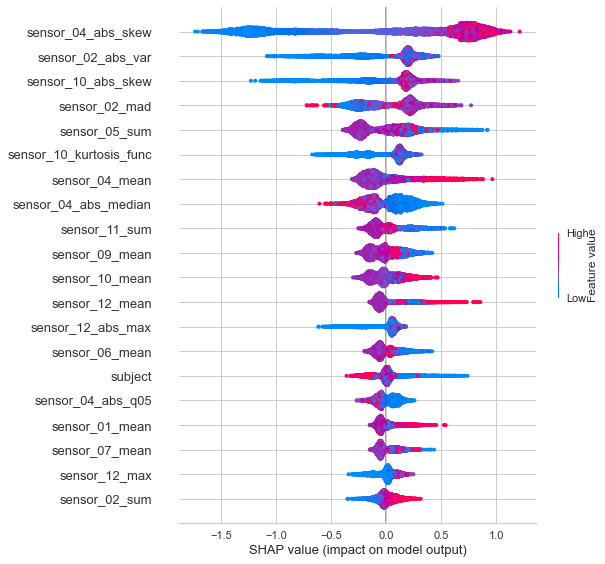

In [29]:
# 過学習していないか確認するために、影響度の大きいものから順番に1個ずつ消していってみる

remove_factor_list = ['sensor_04_kurtosis_func', 'sensor_02_abs_var', 'sensor_10_abs_skew', 'sensor_02_max', 'sensor_05_sum', 'sensor_04_mean', 'sensor_04_abs_median', 'sensor_10_mean', 'sensor_12_abs_max', 'sensor_01_mean', 'sensor_11_mean', 'sensor_12_sum', 'sensor_09_sum', 'subject']
test(remove_factor_list[0])

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8383,0.9147,0.8826,0.8121,0.8459,0.6763,0.6789
1,0.8245,0.9044,0.8641,0.8027,0.8323,0.6488,0.6508
2,0.8219,0.9013,0.8651,0.7995,0.8310,0.6434,0.6457
Mean,0.8282,0.9068,0.8706,0.8048,0.8364,0.6562,0.6585
Std,0.0072,0.0057,0.0085,0.0054,0.0067,0.0144,0.0146


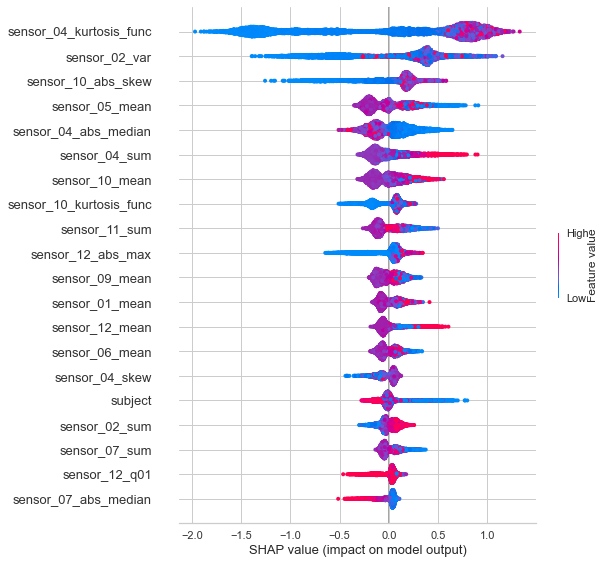

In [33]:
test(remove_factor_list[1])

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8268,0.9078,0.8581,0.8060,0.8312,0.6537,0.6551
1,0.8294,0.9098,0.8792,0.8006,0.8381,0.6586,0.6619
2,0.8320,0.9078,0.8668,0.8160,0.8406,0.6634,0.6647
Mean,0.8294,0.9085,0.8680,0.8075,0.8366,0.6586,0.6605
Std,0.0021,0.0010,0.0087,0.0064,0.0040,0.0039,0.0041


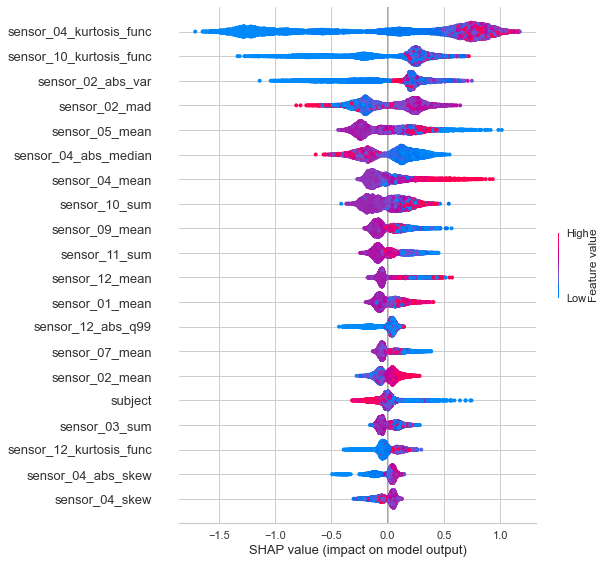

In [31]:
test(remove_factor_list[2])

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8329,0.9112,0.8696,0.8125,0.8401,0.6655,0.6672
1,0.8294,0.9089,0.8687,0.8107,0.8387,0.6581,0.6599
2,0.8259,0.9039,0.8821,0.7905,0.8338,0.6522,0.6565
Mean,0.8294,0.9080,0.8734,0.8046,0.8375,0.6586,0.6612
Std,0.0028,0.0030,0.0061,0.0100,0.0027,0.0054,0.0044


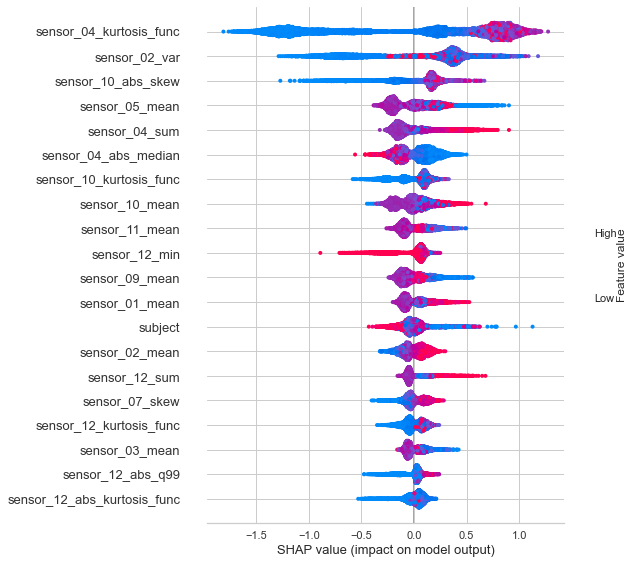

In [32]:
test(remove_factor_list[3])

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8301,0.9087,0.8722,0.8019,0.8356,0.6604,0.6629
1,0.8403,0.9168,0.8732,0.8227,0.8472,0.6803,0.6817
2,0.8261,0.9049,0.8694,0.7974,0.8318,0.6525,0.6551
Mean,0.8322,0.9101,0.8716,0.8073,0.8382,0.6644,0.6666
Std,0.0060,0.0049,0.0016,0.0110,0.0065,0.0117,0.0111


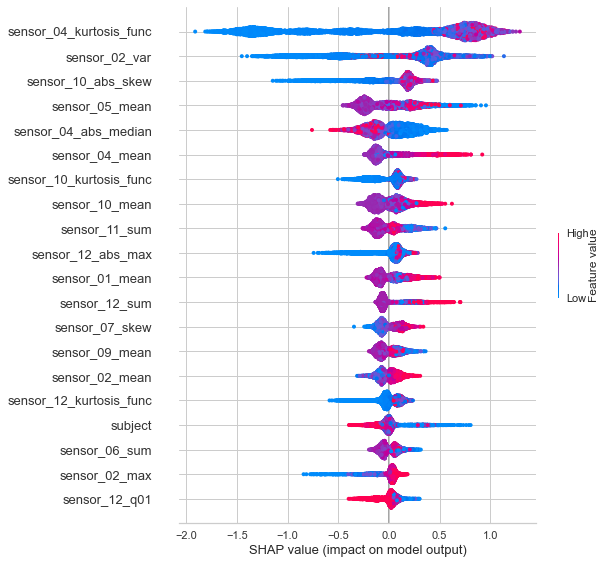

In [34]:
test(remove_factor_list[4])

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8289,0.9053,0.8671,0.8052,0.8350,0.6578,0.6597
1,0.8323,0.9082,0.8802,0.8013,0.8389,0.6649,0.6681
2,0.8310,0.9073,0.8654,0.8113,0.8375,0.6618,0.6632
Mean,0.8307,0.9069,0.8709,0.8060,0.8371,0.6615,0.6637
Std,0.0014,0.0012,0.0066,0.0041,0.0016,0.0029,0.0034


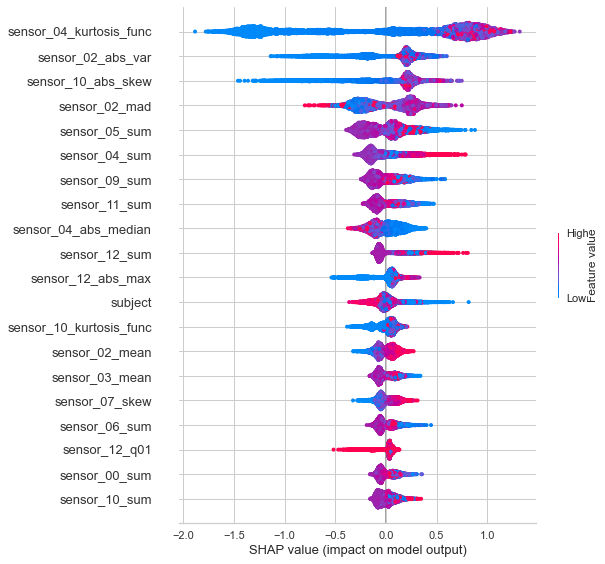

In [35]:
test(remove_factor_list[5])

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8284,0.9067,0.8720,0.8011,0.8351,0.6568,0.6594
1,0.8207,0.9027,0.8691,0.7939,0.8298,0.6412,0.6441
2,0.8297,0.9069,0.8670,0.8064,0.8356,0.6595,0.6614
Mean,0.8263,0.9054,0.8694,0.8005,0.8335,0.6525,0.6550
Std,0.0040,0.0019,0.0021,0.0051,0.0026,0.0081,0.0077


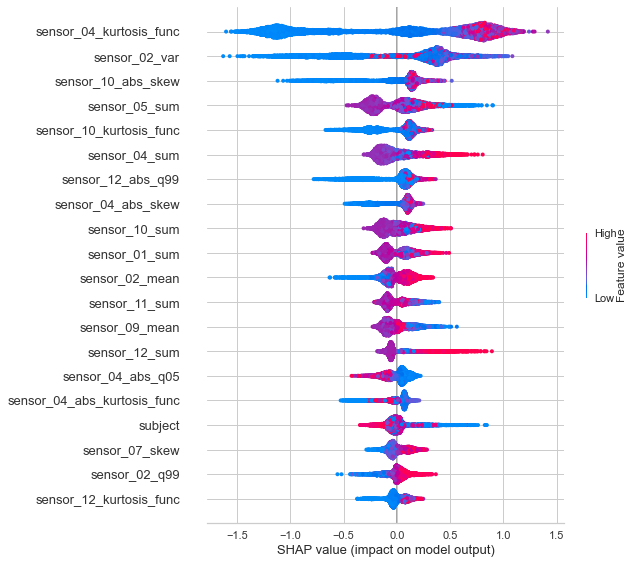

In [36]:
test(remove_factor_list[6])

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8315,0.9094,0.8655,0.8130,0.8384,0.6627,0.6641
1,0.8280,0.9038,0.8760,0.7980,0.8352,0.6562,0.6593
2,0.8207,0.9029,0.8608,0.7972,0.8278,0.6414,0.6434
Mean,0.8267,0.9054,0.8675,0.8027,0.8338,0.6534,0.6556
Std,0.0045,0.0029,0.0064,0.0073,0.0045,0.0089,0.0088


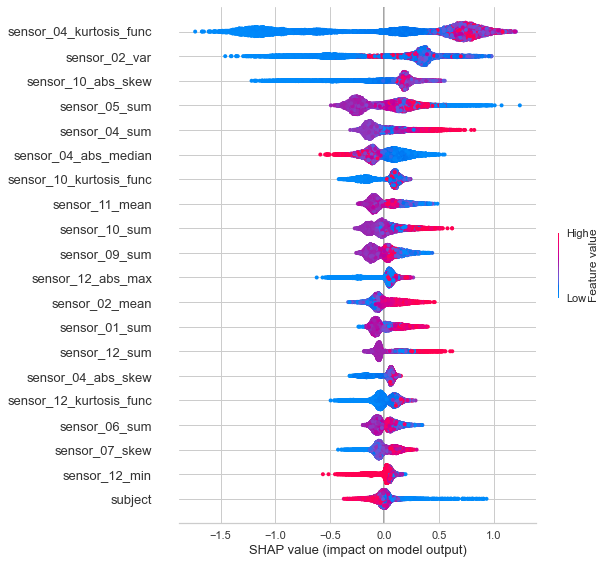

In [37]:
test(remove_factor_list[7])

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8242,0.9075,0.8609,0.8050,0.8320,0.6480,0.6496
1,0.8294,0.9067,0.8686,0.8066,0.8364,0.6587,0.6606
2,0.8296,0.9062,0.8732,0.8018,0.8360,0.6593,0.6619
Mean,0.8277,0.9068,0.8675,0.8045,0.8348,0.6553,0.6574
Std,0.0025,0.0005,0.0051,0.0020,0.0020,0.0052,0.0055


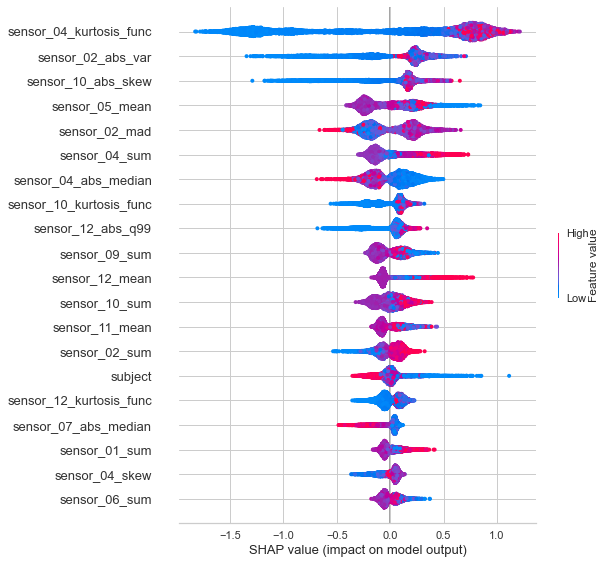

In [38]:
test(remove_factor_list[8])

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8310,0.9079,0.8641,0.8123,0.8374,0.6617,0.6631
1,0.8264,0.9070,0.8749,0.7969,0.8341,0.6530,0.6561
2,0.8365,0.9107,0.8727,0.8189,0.8449,0.6724,0.6740
Mean,0.8313,0.9085,0.8706,0.8094,0.8388,0.6624,0.6644
Std,0.0041,0.0016,0.0046,0.0092,0.0045,0.0080,0.0073


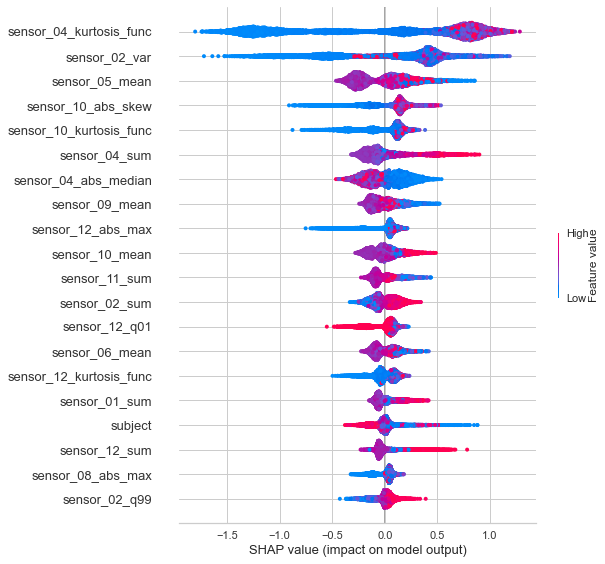

In [39]:
test(remove_factor_list[9])

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8242,0.9001,0.8672,0.8011,0.8328,0.6480,0.6503
1,0.8278,0.9093,0.8609,0.8105,0.8349,0.6554,0.6567
2,0.8259,0.9048,0.8797,0.7913,0.8332,0.6522,0.6563
Mean,0.8260,0.9047,0.8693,0.8009,0.8336,0.6519,0.6544
Std,0.0015,0.0038,0.0078,0.0078,0.0009,0.0030,0.0029


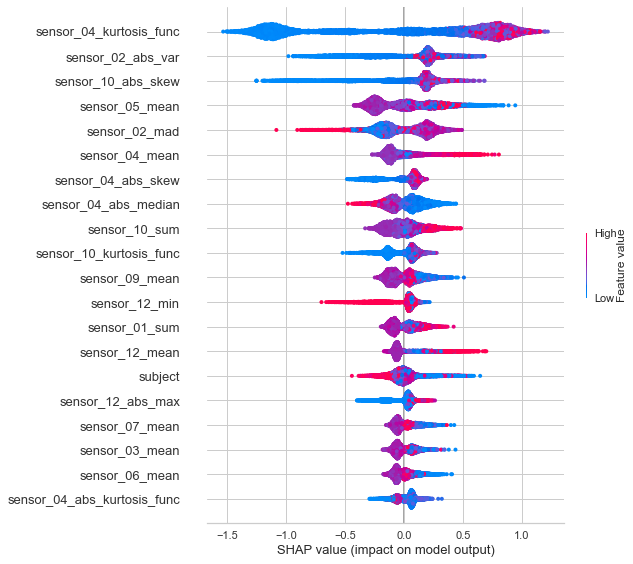

In [40]:
test(remove_factor_list[10])

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8238,0.9019,0.8811,0.7883,0.8321,0.6480,0.6525
1,0.8383,0.9100,0.8680,0.8233,0.8451,0.6761,0.6772
2,0.8235,0.9018,0.8654,0.8008,0.8318,0.6467,0.6488
Mean,0.8285,0.9045,0.8715,0.8041,0.8363,0.6569,0.6595
Std,0.0069,0.0039,0.0069,0.0145,0.0062,0.0136,0.0126


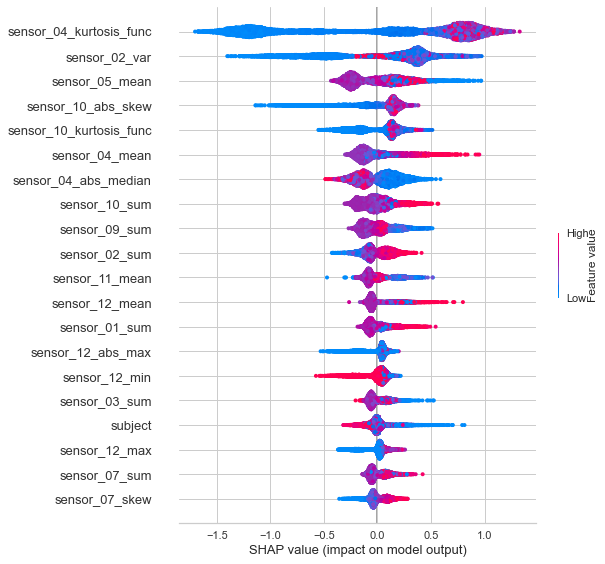

In [41]:
test(remove_factor_list[11])

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8209,0.8994,0.8630,0.8004,0.8306,0.6412,0.6432
1,0.8297,0.9069,0.8681,0.8092,0.8376,0.6592,0.6610
2,0.8254,0.9045,0.8691,0.7940,0.8299,0.6513,0.6541
Mean,0.8253,0.9036,0.8668,0.8012,0.8327,0.6505,0.6528
Std,0.0036,0.0031,0.0027,0.0062,0.0035,0.0074,0.0073


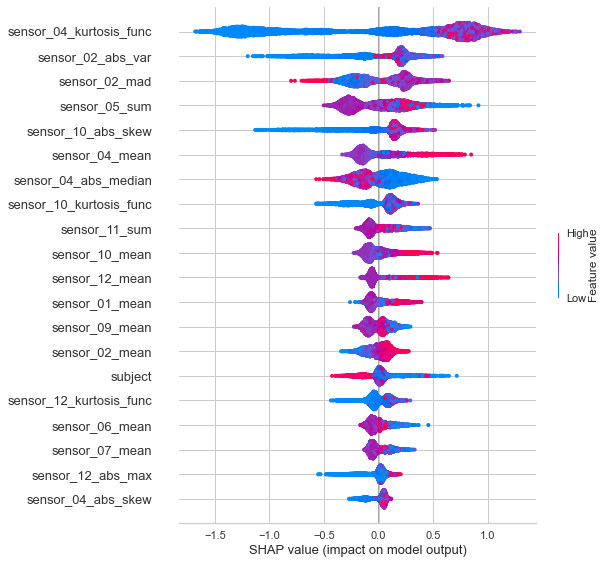

In [42]:
test(remove_factor_list[12])

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8174,0.8977,0.8597,0.7881,0.8223,0.6353,0.6378
1,0.8367,0.9119,0.8744,0.8079,0.8399,0.6738,0.6760
2,0.8287,0.9071,0.8529,0.8183,0.8352,0.6570,0.6576
Mean,0.8276,0.9056,0.8623,0.8048,0.8325,0.6554,0.6571
Std,0.0079,0.0059,0.0090,0.0125,0.0074,0.0158,0.0156


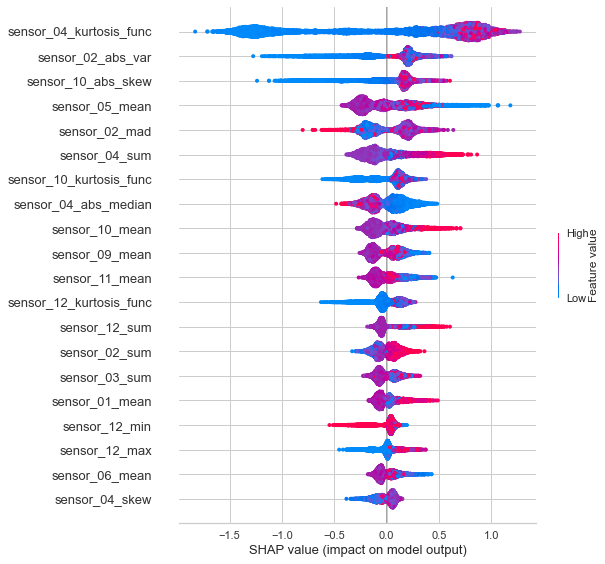

In [43]:
test(remove_factor_list[13])

In [ ]:
final_model = finalize_model(lightgbm_model)
pred = predict_model(final_model, data=test)

In [ ]:
pred.head()

,sequence,subject,size,sensor_00_mean,sensor_00_max,sensor_00_min,sensor_00_var,sensor_00_mad,sensor_00_sum,sensor_00_median,...,sensor_12_abs_sum,sensor_12_abs_median,sensor_12_abs_skew,sensor_12_abs_kurtosis_func,sensor_12_abs_q01,sensor_12_abs_q05,sensor_12_abs_q95,sensor_12_abs_q99,Label,Score
0,25968,684,60,-0.002602,3.146832,-4.950541,1.191898,0.732741,-0.156105,-0.002318,...,17.146206,0.235507,0.725333,-0.636901,0.006603,0.024766,0.718478,0.782728,1,0.8328
1,25969,935,60,0.028516,5.816074,-3.675425,2.102617,0.848916,1.710974,-0.015842,...,33.748082,0.536871,0.223651,-0.925428,0.026522,0.062681,1.145929,1.230055,1,0.7699
2,25970,924,60,0.057664,12.306028,-15.005410,25.843168,4.023308,3.459815,1.079212,...,996.971014,15.883845,0.228238,-0.723526,0.885281,3.887809,31.881202,36.324714,0,0.9785
3,25971,769,60,-0.004791,2.876352,-2.465997,0.837073,0.687991,-0.287481,-0.033617,...,45.496164,0.792199,0.891921,2.548046,0.035132,0.073615,1.409207,1.934045,1,0.6080
4,25972,764,60,-0.001443,17.295209,-9.974498,7.748900,1.083572,-0.086553,-0.171947,...,7729.878517,129.659847,0.436467,-0.229858,2.907928,8.001513,251.436722,325.647711,1,0.7718


In [ ]:
sub.head()

,sequence,state
0,25968,0
1,25969,0
2,25970,0
3,25971,0
4,25972,0


In [ ]:
pred['Label']

0        1
1        1
2        0
3        1
4        1
        ..
12213    1
12214    0
12215    1
12216    0
12217    0
Name: Label, Length: 12218, dtype: int32

In [ ]:
sub = pd.read_csv("../input/tabular-playground-series-apr-2022/sample_submission.csv")
sub

,sequence,state
0,25968,0
1,25969,0
2,25970,0
3,25971,0
4,25972,0
...,...,...
12213,38181,0
12214,38182,0
12215,38183,0
12216,38184,0


In [ ]:
sub['state'] = pred['Label']

In [ ]:
sub.to_csv('submission.csv', index=False)
sub

,sequence,state
0,25968,1
1,25969,1
2,25970,0
3,25971,1
4,25972,1
...,...,...
12213,38181,1
12214,38182,0
12215,38183,1
12216,38184,0
